In [19]:
import pandas as pd

In [20]:
data = pd.read_csv('../01_data/03_final/emission.csv')

In [12]:
data = data.loc[~(data['CO2_Emission'] == 0)]
data = data.loc[~(data['Year'] > 2015)]
data = data.loc[~(data['Year'] < 1998)]

In [13]:
data

,ORSPL,PLANT_NAME,rggi,Low_Income,PRIME_MOVER,UNIT_SIZE,FUEL_TYPE,Year,CO2_Emission,Post
1914,544,Devon Station,1,0,GT,>=25,Oil,1998,37959.550,0
1915,544,Devon Station,1,0,ST,>=25,Oil,1998,1103878.626,0
1919,546,Montville Station,1,0,ST,>=25,Oil,1998,1380947.100,0
1922,548,NRG Norwalk Harbor,1,0,ST,>=25,Oil,1998,1707288.125,0
1927,562,Middletown,1,0,ST,>=25,Natural Gas,1998,2456580.400,0
...,...,...,...,...,...,...,...,...,...,...
92436,58001,Panda Temple Power Station,0,1,CC,>=25,Natural Gas,2015,2905832.601,1
92437,58005,Panda Sherman Power Station,0,0,CC,>=25,Natural Gas,2015,1445300.240,1
92491,58325,Charles D. Lamb Energy Center,0,0,GT,>=25,Natural Gas,2015,26067.588,1
92503,58427,Lansing BWL REO Town Plant,0,1,CC,>=25,Natural Gas,2015,243136.758,1


In [14]:
data_info = data.info()
missing_values = data.isnull().sum()

# Prepare data by subsetting for relevant years (before 2005 and after 2008)
data_pre_2005 = data[data['Year'] < 2005]
data_post_2008 = data[data['Year'] > 2008]

# Display data info, missing values, and the number of rows for the subsetted data
data_info, missing_values, data_pre_2005.shape[0], data_post_2008.shape[0]

<class 'pandas.core.frame.DataFrame'>
Index: 18692 entries, 1914 to 92510
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ORSPL         18692 non-null  int64  
 1   PLANT_NAME    18692 non-null  object 
 2   rggi          18692 non-null  int64  
 3   Low_Income    18692 non-null  int64  
 4   PRIME_MOVER   18692 non-null  object 
 5   UNIT_SIZE     18692 non-null  object 
 6   FUEL_TYPE     18692 non-null  object 
 7   Year          18692 non-null  int64  
 8   CO2_Emission  18692 non-null  float64
 9   Post          18692 non-null  int64  
dtypes: float64(1), int64(5), object(4)
memory usage: 1.6+ MB


(None,
 ORSPL           0
 PLANT_NAME      0
 rggi            0
 Low_Income      0
 PRIME_MOVER     0
 UNIT_SIZE       0
 FUEL_TYPE       0
 Year            0
 CO2_Emission    0
 Post            0
 dtype: int64,
 5610,
 8957)

In [15]:
# Group by 'rggi' and 'Year', and calculate mean CO2 emissions for each group
pre_grouped = data_pre_2005.groupby(['rggi']).CO2_Emission.mean()
post_grouped = data_post_2008.groupby(['rggi']).CO2_Emission.mean()

# Calculate the changes in CO2 emissions for treated and control groups
change_control = post_grouped[0] - pre_grouped[0]
change_treated = post_grouped[1] - pre_grouped[1]

# Calculate the Difference-in-Differences estimator
did_estimator = change_treated - change_control

(pre_grouped, post_grouped, change_control, change_treated, did_estimator)

(rggi
 0    2.670291e+06
 1    1.017030e+06
 Name: CO2_Emission, dtype: float64,
 rggi
 0    1.860540e+06
 1    3.394452e+05
 Name: CO2_Emission, dtype: float64,
 -809751.8250496595,
 -677584.6810390679,
 132167.14401059155)

In [16]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Prepare a dataset for regression by concatenating pre and post datasets and creating an interaction term
data_did = pd.concat([data_pre_2005, data_post_2008])
data_did['post'] = (data_did['Year'] > 2008).astype(int)
data_did['treatment'] = data_did['rggi']
data_did['treatment_post'] = data_did['post'] * data_did['treatment']

# Define and fit the regression model
model = ols('CO2_Emission ~ treatment + post + treatment_post', data=data_did).fit()

# Extract p-value for the interaction term (DiD estimator)
p_value = model.pvalues['treatment_post']

# Create a pivot table for plotting average emissions by year and treatment status
pivot_table = data_did.pivot_table(values='CO2_Emission', index='Year', columns='rggi', aggfunc='mean')

p_value, pivot_table

(0.3465858308499493,
 rggi             0             1
 Year                            
 1998  3.430487e+06  1.767125e+06
 1999  3.231342e+06  1.669280e+06
 2000  3.003731e+06  1.202356e+06
 2001  2.659388e+06  9.604151e+05
 2002  2.359605e+06  8.085067e+05
 2003  2.279141e+06  7.699531e+05
 2004  2.247731e+06  7.576860e+05
 2009  1.928049e+06  3.643034e+05
 2010  1.983262e+06  4.096006e+05
 2011  1.909589e+06  3.334562e+05
 2012  1.810487e+06  3.217426e+05
 2013  1.836396e+06  3.215415e+05
 2014  1.840507e+06  3.188537e+05
 2015  1.716114e+06  3.011162e+05)

In [17]:

# Filter the data for relevant years (before 2005 and after 2008) and exclude zero emissions
pre_2005_filtered = data[(data['Year'] < 2005) & (data['CO2_Emission'] > 0)]
post_2008_filtered = data[(data['Year'] > 2008) & (data['CO2_Emission'] > 0)]

# Group by 'rggi' and 'Year', and calculate mean CO2 emissions for each group
pre_grouped_filtered = pre_2005_filtered.groupby(['rggi']).CO2_Emission.mean()
post_grouped_filtered = post_2008_filtered.groupby(['rggi']).CO2_Emission.mean()

# Calculate the changes in CO2 emissions for treated and control groups
change_control_filtered = post_grouped_filtered[0] - pre_grouped_filtered[0]
change_treated_filtered = post_grouped_filtered[1] - pre_grouped_filtered[1]

# Calculate the Difference-in-Differences estimator
did_estimator_filtered = change_treated_filtered - change_control_filtered

# Creating a table to display the data
results_table = pd.DataFrame({
    "Pre-Treatment Mean Emissions": pre_grouped_filtered,
    "Post-Treatment Mean Emissions": post_grouped_filtered,
    "Change in Control": [change_control_filtered, None],  # No control data for rggi=1
    "Change in Treated": [None, change_treated_filtered],  # No treated data for rggi=0
    "DiD Estimator": [None, did_estimator_filtered]  # Only relevant for treated group
})

results_table

,Pre-Treatment Mean Emissions,Post-Treatment Mean Emissions,Change in Control,Change in Treated,DiD Estimator
rggi,,,,,
0,2.670291e+06,1.860540e+06,-809751.82505,NaN,NaN
1,1.017030e+06,3.394452e+05,NaN,-677584.681039,132167.144011


In [34]:
data2 = data.loc[~(data['Year'] > 2011)].copy()
data2 = data2.loc[~(data['Year'] < 2002)]

pre_2005_filtered = data2[(data2['Year'] < 2005) & (data2['CO2_Emission'] > 0)]
post_2008_filtered = data2[(data2['Year'] > 2008) & (data2['CO2_Emission'] > 0)]

# Group by 'rggi' and 'Year', and calculate mean CO2 emissions for each group
pre_grouped_filtered = pre_2005_filtered.groupby(['rggi']).CO2_Emission.mean()
post_grouped_filtered = post_2008_filtered.groupby(['rggi']).CO2_Emission.mean()

# Calculate the changes in CO2 emissions for treated and control groups
change_control_filtered = post_grouped_filtered[0] - pre_grouped_filtered[0]
change_treated_filtered = post_grouped_filtered[1] - pre_grouped_filtered[1]

# Calculate the Difference-in-Differences estimator
did_estimator_filtered = change_treated_filtered - change_control_filtered

# Creating a table to display the data
results_table = pd.DataFrame({
    "2002-2004 Mean Emissions": pre_grouped_filtered,
    "2009-2011 Mean Emissions": post_grouped_filtered,
    "Change": [change_control_filtered, change_treated_filtered],
    "DiD Estimator": ['--', did_estimator_filtered]  # Only relevant for treated group
})

results_table

,2002-2004 Mean Emissions,2009-2011 Mean Emissions,Change,DiD Estimator
rggi,,,,
0,2.294150e+06,1.940403e+06,-353747.454527,--
1,7.779527e+05,3.687194e+05,-409233.372813,-55485.918287


<Figure size 1200x600 with 0 Axes>

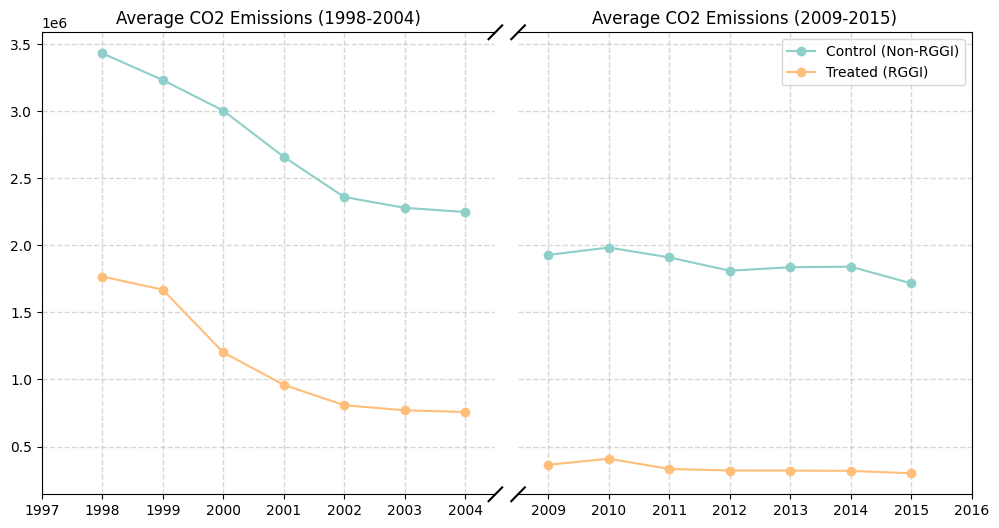

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

# Define two subplots with a shared y-axis
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
fig.subplots_adjust(wspace=0.05)  # Adjust space between the plots
colors = ['#8ECFC9','#FFBE7A']
# Plotting with standard axis for pre-2005 and post-2008
ax1.plot(pivot_table.index[pivot_table.index < 2005], pivot_table[0][pivot_table.index < 2005],color=colors[0],label='Control (Non-RGGI)', marker='o')
ax1.plot(pivot_table.index[pivot_table.index < 2005], pivot_table[1][pivot_table.index < 2005],color=colors[1], label='Treated (RGGI)', marker='o')
ax2.plot(pivot_table.index[pivot_table.index > 2008], pivot_table[0][pivot_table.index > 2008],color=colors[0], marker='o', label='Control (Non-RGGI)')
ax2.plot(pivot_table.index[pivot_table.index > 2008], pivot_table[1][pivot_table.index > 2008],color=colors[1], marker='o', label='Treated (RGGI)')

# Set the limits for the x-axis to create a broken axis effect
ax1.set_xlim(1997, 2004.5)  # data up to 2005
ax2.set_xlim(2008.5, 2016)  # data from 2008 onwards

# Hide the spines between ax1 and ax2
ax1.spines.right.set_visible(False)
ax2.spines.left.set_visible(False)

# Hide the y-ticks on the second subplot
ax2.tick_params(axis='y', which='both', length=0)

# Add grid lines
ax1.grid(ls='--', alpha=0.5, linewidth=1)
ax2.grid(ls='--', alpha=0.5, linewidth=1)

# Create the 'break' marks on the axes
d = .015  # length of diagonal lines at breaks
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)
ax1.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)
ax2.plot((-d, +d), (-d, +d), **kwargs)

# Add legends and set titles
ax2.legend(loc='upper right')
ax1.set_title('Average CO2 Emissions (1998-2004)')
ax2.set_title('Average CO2 Emissions (2009-2015)')

plt.show()

In [33]:
import statsmodels.api as sm
# Prepare the data for regression analysis with interaction term
data['post_treatment'] = data['Post'] * data['rggi']

# Defining the model: CO2_Emission ~ treatment + post + post_treatment
X_filtered = data[['rggi', 'Post', 'post_treatment']]
X_filtered = sm.add_constant(X_filtered)
y_filtered = data['CO2_Emission']

# Fit the model
model_filtered = sm.OLS(y_filtered, X_filtered).fit()

# Getting the summary of the model
model_filtered_summary = model_filtered.summary()
print(model_filtered_summary)

                            OLS Regression Results                            
Dep. Variable:           CO2_Emission   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     120.5
Date:                Wed, 01 May 2024   Prob (F-statistic):           6.74e-78
Time:                        02:59:35   Log-Likelihood:            -1.5234e+06
No. Observations:               96281   AIC:                         3.047e+06
Df Residuals:                   96277   BIC:                         3.047e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           4.867e+05   7936.158     61.

In [32]:
import statsmodels.api as sm
# Prepare the data for regression analysis with interaction term
data2['post_treatment'] = data2['Post'] * data2['rggi']

# Defining the model: CO2_Emission ~ treatment + post + post_treatment
X_filtered = data2[['rggi', 'Post', 'post_treatment']]
X_filtered = sm.add_constant(X_filtered)
y_filtered = data2['CO2_Emission']

# Fit the model
model_filtered = sm.OLS(y_filtered, X_filtered).fit()

# Getting the summary of the model
model_filtered_summary = model_filtered.summary()
print(model_filtered_summary)

                            OLS Regression Results                            
Dep. Variable:           CO2_Emission   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     54.31
Date:                Wed, 01 May 2024   Prob (F-statistic):           4.97e-35
Time:                        02:58:27   Log-Likelihood:            -6.9382e+05
No. Observations:               43755   AIC:                         1.388e+06
Df Residuals:                   43751   BIC:                         1.388e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           5.016e+05   1.16e+04     43.